# Data wrangling procedure from NDA

in this script we used a set of self written function to clean the rawdata from NDA

In [1]:
#import libraries
from strat.create_dataset import dataset, prepare_imputation
from strat.run_rcv_vero import RCV, relabel # modify here by vero
#from strat.run_rcv_vero_noumap import RCV, relabel # modify here by vero
import sklearn
import strat.utils as ut # in the utils file you can specify the directories
import logging
import numpy as np
import pandas as pd
from strat.create_long_ndar import build_long
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
import re
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from strat.ucsd_dataset import prepare_ucsd, predict_labels, create_new
import pickle as pkl
import os
from reval.best_nclust_cv import FindBestClustCV
from sklearn.cluster import KMeans
from strat.visualization import _scatter_plot
from strat.run_rcv_vero import _build_distmat
import tqdm

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s',
                    level=logging.INFO, datefmt='%I:%M:%S')

In [2]:
#check directories
print(ut.raw_data_folder)
print(ut.out_folder)

~/OneDrive - Fondazione Istituto Italiano Tecnologia/vineland_proj_edition/data/raw
/Users/vmandelli/OneDrive - Fondazione Istituto Italiano Tecnologia/vineland_proj_edition/results


## Import Vineland datasets from NDAR and clean data

In [3]:
# merge all the vineland dataset using the function dataset dwoloaded from NDA

vineland, demo_info = dataset(ut.instrument_dict, # dictionary for the instrument (Vinaland files) to use specified in the utils.py file
                              ut.phenotype_file, # dictionary for the phenotypes specified in the utils.py file
                              phenotype='autism', # phenotype included in the analis 
                              ptype=2, # ptype = how to create the age bins, "2" creates 2 bins (split at 72 months), "1" creates 5 bins
                              save=True)  # saving options# ptype = How Isotta created the age bins --> there are 2 ways p2 keeps only underd 72 and over 72 months

# the output

09:17:16, INFO Select individuals with autism and save demographic info.
09:17:38, INFO Number of subjects with autism: 17772


09:17:38, INFO Loading datasets:
09:17:38, INFO vinelandsurvey_200505
09:17:39, INFO Read table vinelandsurvey_200505 -- N subjects (unique): 2872 (1513)

09:17:39, INFO vinelandparent_200503
09:17:40, INFO Read table vinelandparent_200503 -- N subjects (unique): 1904 (1290)

09:17:40, INFO vinland301
09:17:40, INFO Read table vinland301 -- N subjects (unique): 1818 (445)

09:17:40, INFO Processing VINELAND
09:17:41, INFO Dropped 104 observations with completely missing information
09:17:41, INFO Dropped 1544 duplicated observations
09:17:41, INFO Dropped 357 subjects from UCSD longitudinal study
09:17:41, INFO Current number of observation: 4589




In [4]:
#take a look at the VINELAND 
vineland.head(10) 
vineland.to_csv(os.path.join('~/OneDrive - Fondazione Istituto Italiano Tecnologia/vineland_proj_edition','results','data_NDA_wrangled.csv'))


In [5]:
col2use = ['interview_period',
           'collection_id',
           'interview_age',
           'edition',
           'communicationdomain_totalb',
           'livingskillsdomain_totalb',
           'socializationdomain_totalb',
           'motorskillsdomain_totalb',
           'composite_totalb',
           'sex'
          ]
vineland_P1 = vineland[vineland["interview_period"]=="P1"][col2use]
print(vineland_P1.shape)
vineland_P1.head()

(1739, 10)


,interview_period,collection_id,interview_age,edition,communicationdomain_totalb,livingskillsdomain_totalb,socializationdomain_totalb,motorskillsdomain_totalb,composite_totalb,sex
subjectkey,,,,,,,,,,
NDARAA668AC0,P1,1.0,50.0,2.0,72.0,55.0,66.0,72.0,63.0,M
NDARAA864ZGK,P1,1600.0,64.0,2.0,NaN,51.0,NaN,NaN,NaN,M
NDARAB839WV5,P1,2262.0,59.0,2.0,81.0,62.0,65.0,67.0,65.0,M
NDARAB989DG5,P1,2368.0,38.0,2.0,63.0,73.0,68.0,70.0,65.0,M
NDARAB989DG5,P1,2368.0,53.0,2.0,59.0,75.0,72.0,70.0,66.0,M


In [6]:
vineland_P1['countna'] = vineland_P1[['communicationdomain_totalb', 'livingskillsdomain_totalb','socializationdomain_totalb',
           'motorskillsdomain_totalb']].isnull().sum(axis=1)
vineland_P1.head(100)

,interview_period,collection_id,interview_age,edition,communicationdomain_totalb,livingskillsdomain_totalb,socializationdomain_totalb,motorskillsdomain_totalb,composite_totalb,sex,countna
subjectkey,,,,,,,,,,,
NDARAA668AC0,P1,1.0,50.0,2.0,72.0,55.0,66.0,72.0,63.0,M,0
NDARAA864ZGK,P1,1600.0,64.0,2.0,NaN,51.0,NaN,NaN,NaN,M,3
NDARAB839WV5,P1,2262.0,59.0,2.0,81.0,62.0,65.0,67.0,65.0,M,0
NDARAB989DG5,P1,2368.0,38.0,2.0,63.0,73.0,68.0,70.0,65.0,M,0
NDARAB989DG5,P1,2368.0,53.0,2.0,59.0,75.0,72.0,70.0,66.0,M,0
...,...,...,...,...,...,...,...,...,...,...,...
NDARBA937RWA,P1,1.0,67.0,2.0,83.0,95.0,86.0,97.0,88.0,M,0
NDARBB514BHJ,P1,2262.0,48.0,2.0,54.0,64.0,66.0,75.0,62.0,M,0
NDARBC943ACW,P1,2777.0,41.0,2.0,47.0,89.0,68.0,81.0,68.0,M,0


In [7]:
# Remove duplicates and retain the row with the lowest missing info
df = vineland_P1
mask = df.reset_index().duplicated(['subjectkey', 'interview_period'], keep=False)
dfdup = df.loc[mask.tolist()].copy()
gui_list = np.unique(dfdup.index)
mask_drop = []
for idx in gui_list:
    cou = dfdup.loc[idx].countna.tolist() ### non trovo questa funzione
    tmp = [False] * dfdup.loc[idx].shape[0]
    tmp[cou.index(min(cou))] = True
    mask_drop.extend(tmp)
df_out = pd.concat([dfdup.loc[mask_drop], df.loc[(~mask).tolist()]])
df_out.sort_values(['subjectkey', 'interview_period'], inplace=True)

In [8]:
print(vineland_P1.shape)
df_out.shape

(1739, 11)


(1125, 11)

In [63]:
# drop those with more than 1 missing data
vineland_final = df_out[df_out['countna']<=1]
print(vineland_final.shape)
vineland_final.to_csv(os.path.join('~/OneDrive - Fondazione Istituto Italiano Tecnologia/vineland_proj_edition','results','NDA_P1_T1.csv'))


(1098, 11)


In [58]:
vineland_final

,ageyrs_round,interview_period,collection_id,interview_age,edition,communicationdomain_totalb,livingskillsdomain_totalb,socializationdomain_totalb,motorskillsdomain_totalb,composite_totalb,sex,countna
subjectkey,,,,,,,,,,,,
NDARAA668AC0,4.0,P1,1.0,50.0,2.0,72.0,55.0,66.0,72.0,63.0,M,0
NDARAB839WV5,5.0,P1,2262.0,59.0,2.0,81.0,62.0,65.0,67.0,65.0,M,0
NDARAB989DG5,3.0,P1,2368.0,38.0,2.0,63.0,73.0,68.0,70.0,65.0,M,0
NDARAC070DYV,3.0,P1,2114.0,39.0,3.0,NaN,98.0,95.0,82.0,NaN,M,1
NDARAC098YNP,5.0,P1,2442.0,62.0,2.0,91.0,71.0,77.0,84.0,77.0,M,0
...,...,...,...,...,...,...,...,...,...,...,...,...
NDAR_INVZRUM2J2K,2.0,P1,2666.0,21.0,2.0,87.0,107.0,84.0,81.0,87.0,M,0
NDAR_INVZS189UNQ,2.0,P1,2368.0,28.0,2.0,56.0,69.0,58.0,72.0,61.0,F,0
NDAR_INVZT746UZR,2.0,P1,2666.0,21.0,2.0,97.0,96.0,73.0,95.0,88.0,M,0


In [57]:
## train test split
file = 'edition_subids.csv'
edition = pd.read_csv(os.path.join('~/OneDrive - Fondazione Istituto Italiano Tecnologia/vineland_proj_edition','results',file),index_col='subjectkey')
edition.head()  
print(edition.shape)
edition.head()
edition2use = edition[['format']].copy()
vineland_edition = pd.merge(vineland_final,edition2use,left_index = True , right_index=True)
vineland_edition




(1098, 6)


,ageyrs_round,interview_period,collection_id,interview_age,edition,communicationdomain_totalb,livingskillsdomain_totalb,socializationdomain_totalb,motorskillsdomain_totalb,composite_totalb,sex,countna,format
subjectkey,,,,,,,,,,,,,
NDARAA668AC0,4.0,P1,1.0,50.0,2.0,72.0,55.0,66.0,72.0,63.0,M,0,survey
NDARAB839WV5,5.0,P1,2262.0,59.0,2.0,81.0,62.0,65.0,67.0,65.0,M,0,interview
NDARAB989DG5,3.0,P1,2368.0,38.0,2.0,63.0,73.0,68.0,70.0,65.0,M,0,survey
NDARAC070DYV,3.0,P1,2114.0,39.0,3.0,NaN,98.0,95.0,82.0,NaN,M,1,ed_3
NDARAC098YNP,5.0,P1,2442.0,62.0,2.0,91.0,71.0,77.0,84.0,77.0,M,0,survey
...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDAR_INVZRUM2J2K,2.0,P1,2666.0,21.0,2.0,87.0,107.0,84.0,81.0,87.0,M,0,survey
NDAR_INVZS189UNQ,2.0,P1,2368.0,28.0,2.0,56.0,69.0,58.0,72.0,61.0,F,0,survey
NDAR_INVZT746UZR,2.0,P1,2666.0,21.0,2.0,97.0,96.0,73.0,95.0,88.0,M,0,survey


<ipython-input-43-c43d7f967acf>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vineland_edition[vineland_final['edition']==3.0]['interview_age'].hist()


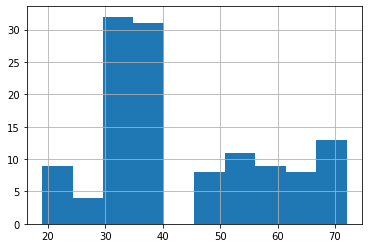

In [43]:
vineland_edition[vineland_final['edition']==3.0]['interview_age'].hist()

In [59]:
#train_test split
from sklearn.model_selection import train_test_split
#vineland_edition.insert(0, 'ageyrs_round',round(vineland_edition.interview_age/12))

dict_df = vineland_edition
tr_dict, ts_dict = {}, {}
idx_tr, idx_ts = train_test_split(dict_df.index,
                                  stratify=dict_df[['sex', 'ageyrs_round','format']],
                                  test_size=0.45,
                                  random_state=42)

tr_dict = dict_df.loc[idx_tr]
ts_dict= dict_df.loc[idx_ts]#.sort_values(['subjectkey','interview_period','format'])


In [60]:
tr_dict.to_csv(os.path.join('~/OneDrive - Fondazione Istituto Italiano Tecnologia/vineland_proj_edition','results','NDA_P1_tr_041022.csv'))
ts_dict.to_csv(os.path.join('~/OneDrive - Fondazione Istituto Italiano Tecnologia/vineland_proj_edition','results','NDA_P1_ts_041022.csv'))


In [61]:
print(tr_dict.shape)

(603, 13)


In [62]:
ts_dict.shape

(495, 13)